# Introduction: Feature Selection¶
In this notebook we will apply feature engineering to the manual engineered features built in two previous notebook. We will reduce the number of features using several methods and then we will test the performance of the features using a fairly basic gradient boosting machine model.

The full set of features was built in Manual Feature Engineering(previous notebook)

We will use three methods for feature selection:

1. Remove collinear features
2. Remove features with greater than a threshold percentage of missing values
3. Keep only the most relevant features using feature importances from a model

Standard imports for data science work. The LightGBM library is used for the gradient boosting machine.


In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

In [2]:
#read in data
categoricals = ['CRASH_DATE_EST_I', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE',
                'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND',
                'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
                'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE',
                'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION', 'STREET_NAME', 'PHOTOS_TAKEN_I',
                'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I',
                'MOST_SEVERE_INJURY', 'BEAT_OF_OCCURRENCE','CRASH_HOUR','CRASH_MONTH','CRASH_DAY_OF_WEEK','YEAR']
dtypes = dict.fromkeys(categoricals, 'category')


df = pd.read_csv('../input/00_injury_train_people_vehicle_corrs_removed.csv', dtype = dtypes)
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207101 entries, 0 to 207100
Columns: 122 entries, RD_NO to vehicle_VEHICLE_TYPE_VAN/MINI-VAN_count
dtypes: category(19), float64(94), int64(3), object(6)
memory usage: 167.0+ MB


(207101, 122)

There are 207,101 rows and 122 features in the dataset.

we are dropping some variables with date and IDs and location information which are not important for modeling.

In [3]:
# save the ids and target
df_labels = df['TARGET']
df_ids = df['RD_NO']

In [4]:
# drop variables (REPORT_TYPE, FIRST_CRASH_TYPE: data leakage)
drop_columns =  ['RD_NO','REPORT_TYPE','FIRST_CRASH_TYPE','CRASH_DATE', 'DATE_POLICE_NOTIFIED', 'STREET_NAME','STREET_NO','BEAT_OF_OCCURRENCE','LATITUDE','LONGITUDE','LOCATION']
df = df.drop(columns=drop_columns)
df.shape

(207101, 111)

## Remove Collinear Variables

Since we haved added some numrical features from other tables. We are checing collinearity.
Collinear variables can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set. Clearly, these are three things we want to increase, so removing collinear variables is a useful step. We will establish an admittedly arbitrary threshold for removing collinear variables, and then remove one out of any pair of variables that is above that threshold.

In [5]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = df.corr().abs()
corr_matrix.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,people_counts,TARGET,people_AGE_count,people_AGE_mean,SEX_F_count,SEX_F_count_norm,SEX_M_count,SEX_M_count_norm,...,vehicle_VEHICLE_TYPE_OTHER VEHICLE WITH TRAILER_count,vehicle_VEHICLE_TYPE_PASSENGER_count,vehicle_VEHICLE_TYPE_PICKUP_count,vehicle_VEHICLE_TYPE_SNOWMOBILE_count,vehicle_VEHICLE_TYPE_SPORT UTILITY VEHICLE (SUV)_count,vehicle_VEHICLE_TYPE_TRACTOR W/ SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRACTOR W/O SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRUCK - SINGLE UNIT_count,vehicle_VEHICLE_TYPE_UNKNOWN/NA_count,vehicle_VEHICLE_TYPE_VAN/MINI-VAN_count
POSTED_SPEED_LIMIT,1.000000,0.049491,0.118641,0.103594,0.136088,0.039065,0.065305,0.026112,0.115151,0.065009,...,0.002673,0.072215,0.009332,0.001294,0.007552,0.008286,0.003318,0.016044,0.061501,0.009958
NUM_UNITS,0.049491,1.000000,0.213388,0.104067,0.178914,0.033915,0.117653,0.017728,0.139384,0.017419,...,0.000756,0.398321,0.060508,0.000295,0.108460,0.040797,0.006118,0.011399,0.056225,0.075619
people_counts,0.118641,0.213388,1.000000,0.123914,0.732453,0.149559,0.615640,0.182377,0.586406,0.053648,...,0.005240,0.143978,0.003001,0.003878,0.069928,0.031596,0.004289,0.026141,0.187885,0.038532
TARGET,0.103594,0.104067,0.123914,1.000000,0.212941,0.094599,0.081108,0.028287,0.108621,0.056674,...,0.010524,0.073465,0.006498,0.002789,0.012298,0.017096,0.002676,0.033919,0.119476,0.000366
people_AGE_count,0.136088,0.178914,0.732453,0.212941,1.000000,0.172456,0.528030,0.232781,0.532504,0.171365,...,0.008511,0.195517,0.015933,0.003306,0.063535,0.001863,0.007087,0.004612,0.338849,0.034794


In [6]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,people_counts,TARGET,people_AGE_count,people_AGE_mean,SEX_F_count,SEX_F_count_norm,SEX_M_count,SEX_M_count_norm,...,vehicle_VEHICLE_TYPE_OTHER VEHICLE WITH TRAILER_count,vehicle_VEHICLE_TYPE_PASSENGER_count,vehicle_VEHICLE_TYPE_PICKUP_count,vehicle_VEHICLE_TYPE_SNOWMOBILE_count,vehicle_VEHICLE_TYPE_SPORT UTILITY VEHICLE (SUV)_count,vehicle_VEHICLE_TYPE_TRACTOR W/ SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRACTOR W/O SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRUCK - SINGLE UNIT_count,vehicle_VEHICLE_TYPE_UNKNOWN/NA_count,vehicle_VEHICLE_TYPE_VAN/MINI-VAN_count
POSTED_SPEED_LIMIT,NaN,0.049491,0.118641,0.103594,0.136088,0.039065,0.065305,0.026112,0.115151,0.065009,...,0.002673,0.072215,0.009332,0.001294,0.007552,0.008286,0.003318,0.016044,0.061501,0.009958
NUM_UNITS,NaN,NaN,0.213388,0.104067,0.178914,0.033915,0.117653,0.017728,0.139384,0.017419,...,0.000756,0.398321,0.060508,0.000295,0.108460,0.040797,0.006118,0.011399,0.056225,0.075619
people_counts,NaN,NaN,NaN,0.123914,0.732453,0.149559,0.615640,0.182377,0.586406,0.053648,...,0.005240,0.143978,0.003001,0.003878,0.069928,0.031596,0.004289,0.026141,0.187885,0.038532
TARGET,NaN,NaN,NaN,NaN,0.212941,0.094599,0.081108,0.028287,0.108621,0.056674,...,0.010524,0.073465,0.006498,0.002789,0.012298,0.017096,0.002676,0.033919,0.119476,0.000366
people_AGE_count,NaN,NaN,NaN,NaN,NaN,0.172456,0.528030,0.232781,0.532504,0.171365,...,0.008511,0.195517,0.015933,0.003306,0.063535,0.001863,0.007087,0.004612,0.338849,0.034794


In [7]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 1 columns to remove.


In [8]:
to_drop

['SAFETY_EQUIPMENT_USAGE UNKNOWN_count_norm']

In [9]:
# Drop Correlated Variables
df_imputed = df.drop(columns = to_drop)

print('Training shape: ', df_imputed.shape)

Training shape:  (207101, 110)


## Remove Missing Values
There is no right way to choose the threshold for missing values.
In this implementation, if any columns have greater than 70% missing values, they will be removed, which has been done on feature engineering process

In [12]:
# Train missing values (in percent)
df_imputed_missing = (df_imputed.isnull().sum() / len(df_imputed))
df_imputed_missing = df_imputed_missing.sort_values(ascending = False)
df_imputed_missing.head()

LANE_CNT                                       0.338627
people_AGE_mean                                0.176271
SAFETY_EQUIPMENT_CHILD RESTRAINT USED_count    0.015649
SAFETY_EQUIPMENT_NONE PRESENT_count            0.015649
AIRBAG_DEPLOYED_NOT APPLICABLE_count_norm      0.015649
dtype: float64

In [13]:
# Identify missing values above threshold
missing = df_imputed_missing.index[df_imputed_missing > 0.70]
missing = list(set(missing))

In [14]:
f'There are {len(missing)} columns with more than 75% missing values'

'There are 0 columns with more than 75% missing values'

Let's drop the columns, one-hot encode the dataframes, and then align the columns of the dataframes.
There are some variables with NaN value. GBM can handle the missing data, so we are going to replace NaN value.



In [15]:
# One Hot Encoding
df_onehot = pd.get_dummies(df_imputed.drop(columns=missing))

# drop special characters: it will cause issues later

df_onehot.columns=df_onehot.columns.str.replace(r'[$]', '')
df_onehot.columns=df_onehot.columns.str.replace(r'[/]', '')
df_onehot.columns=df_onehot.columns.str.replace(r'[,]', '')
df_onehot.columns=df_onehot.columns.str.replace(r'[-]', '')

                                               
# Extract features and labels
labels = df_onehot['TARGET']
features = df_onehot.drop('TARGET', axis = 1)

# List of features for later use
feature_list = list(features.columns)

In [16]:
# Training and Testing Sets
from sklearn.model_selection import train_test_split

train, test, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25, random_state = 2003)

In [17]:
print('Train Features Shape:', train.shape)
print('Train Labels Shape:', train_labels.shape)
print('Test Features Shape:', test.shape)
print('Test Labels Shape:', test_labels.shape)

Train Features Shape: (155325, 345)
Train Labels Shape: (155325,)
Test Features Shape: (51776, 345)
Test Labels Shape: (51776,)


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155325 entries, 45759 to 179592
Columns: 345 entries, POSTED_SPEED_LIMIT to YEAR_2017
dtypes: float64(91), int64(1), uint8(253)
memory usage: 147.7 MB


In [19]:
# save to csv
train.to_csv('../output/00_injury_GBM_onehot.csv')

## Feature Selection through Feature Importances
We can employ for feature selection is to use the feature importances of a model. The relative value of the importances can be used as an approximation of the "relevance" of different features in a model. Moreover, we can use the feature importances to remove features that the model does not consider important.
By first, removing all zero importance features from the model. If this leaves too many features, then we can consider removing the features with the lowest importance. 

Since the LightGBM model does not need missing values to be imputed, we can directly fit on the training data. We will use Early Stopping to determine the optimal number of iterations and run the model twice, averaging the feature importances to try and avoid overfitting to a certain set of features.

In [20]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss',
                           n_estimators = 10000, class_weight = 'balanced')

In [21]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels,
                                                                        test_size = 0.25, random_state = i)
    
    # Train using early stopping    
    model.fit(train_features, train_y, early_stopping_rounds=100,
              eval_set = [(valid_features, valid_y)],
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.887569	valid_0's binary_logloss: 0.408273
Early stopping, best iteration is:
[242]	valid_0's auc: 0.887914	valid_0's binary_logloss: 0.406821
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.889291	valid_0's binary_logloss: 0.406789
Early stopping, best iteration is:
[222]	valid_0's auc: 0.889578	valid_0's binary_logloss: 0.405142


In [22]:
# Make sure to average feature importances
feature_importances = feature_importances / 2

# making fi table
feature_importances = pd.DataFrame({'feature':list(train.columns) , 'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances.head()

,feature,importance
4,people_AGE_mean,563.0
18,AIRBAG_DEPLOYED_DID NOT DEPLOY_count_norm,210.5
3,people_AGE_count,184.0
1,NUM_UNITS,140.5
83,vehicle_VEHICLE_TYPE_PASSENGER_count,132.5


In [23]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print(f'There are {len(zero_features)} features with 0.0 importance')
feature_importances.tail()

There are 64 features with 0.0 importance


,feature,importance
170,LANE_CNT_60.0,0.0
169,LANE_CNT_45.0,0.0
168,LANE_CNT_41.0,0.0
167,LANE_CNT_40.0,0.0
172,LANE_CNT_99.0,0.0


We see that one of our features made it into the top 5 most important! That's a good sign for all of our hard work making the features. It also looks like many of the features we made have literally 0 importance. For the gradient boosting machine, features with 0 importance are not used at all to make any splits. Therefore, we can remove these features from the model with no effect on performance (except for faster training)

In [24]:
def plot_feature_importances(df, threshold = 0.90):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.90
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

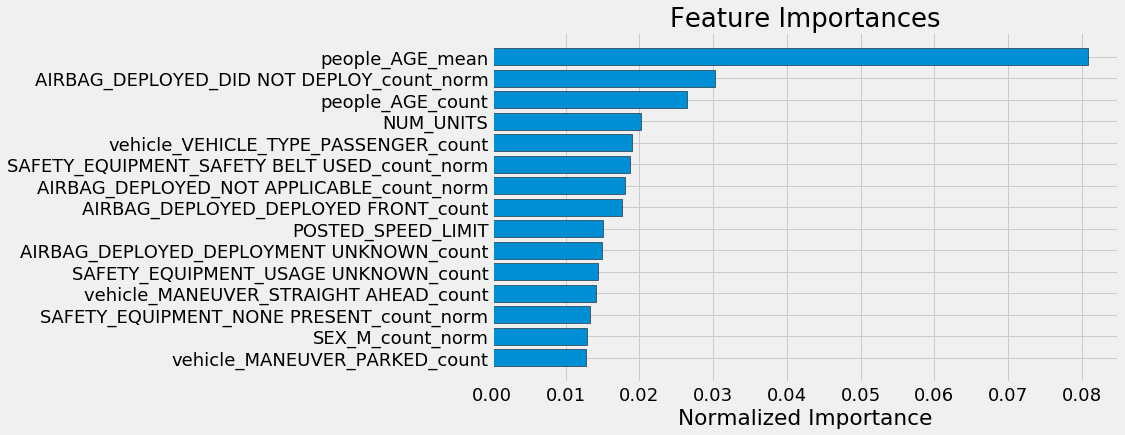

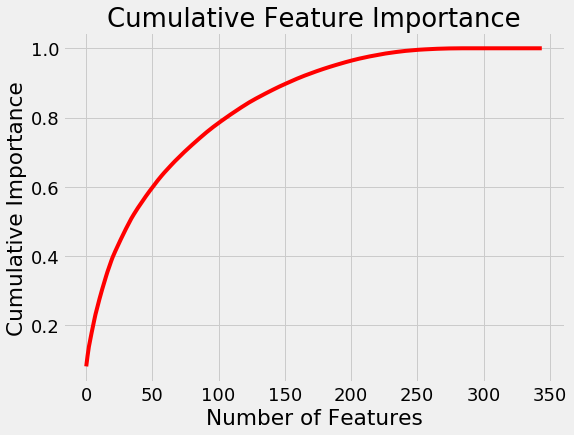

153 features required for 0.90 of cumulative importance


In [25]:
plt.style.use('fivethirtyeight')
norm_feature_importances = plot_feature_importances(feature_importances)

Remove the features that have zero importance.



In [26]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (155325, 281)
Testing shape:  (51776, 281)


At this point, we can re-run the model to see if it identifies any more features with zero importance. In a way, we are implementing our own form of recursive feature elimination. Since we are repeating work, we should probably put the zero feature importance identification code in a function.

In [27]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print(f'\nThere are {len(zero_features)} features with 0.0 importance')
    
    return zero_features, feature_importances

In [28]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.887569	valid_0's binary_logloss: 0.408273
Early stopping, best iteration is:
[242]	valid_0's auc: 0.887914	valid_0's binary_logloss: 0.406821
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.889291	valid_0's binary_logloss: 0.406789
Early stopping, best iteration is:
[222]	valid_0's auc: 0.889578	valid_0's binary_logloss: 0.405142

There are 0 features with 0.0 importance


There are now no 0 importance features left as expected. If we want to remove more features, we will have to start with features that have a non-zero importance. One way we could do this is by retaining enough features to account for a threshold percentage of importance, such as 95%. At this point, let's keep enough features to account for 95% of the importance.

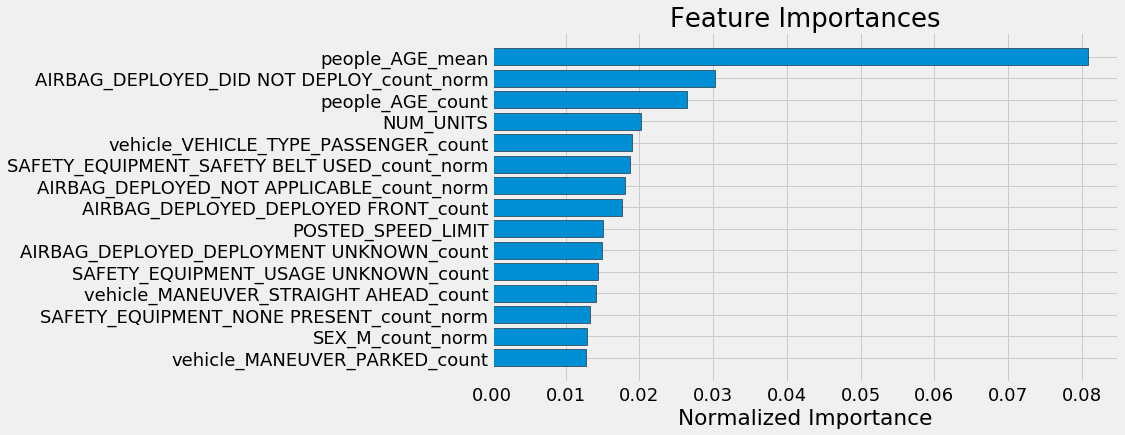

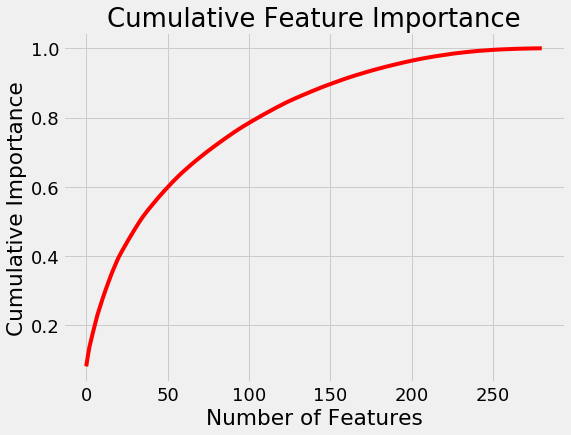

189 features required for 0.95 of cumulative importance


In [29]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

### Limit Number of Features
We will now reduce the number of features in use by the model to only those required to account for 95% of the importance. The same number of features must be used in the training and testing sets.

In [30]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

train_small.to_csv('../output/injury_train_small.csv', index = False)
test_small.to_csv('../output/injury_test_small.csv', index = False)


In [89]:
base_clf =  lgb.LGBMClassifier(objective='binary', boosting_type = 'goss',
                               n_estimators = 10000, class_weight = 'balanced')
base_clf.fit(train_small,train_labels) 

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [90]:
train_gbm_predictions = base_clf.predict(train_small)
train_gbm_probs = base_clf.predict_proba(train_small)[:, 1]

gbm_predictions = base_clf.predict(test_small)
gbm_probs = base_clf.predict_proba(test_small)[:, 1]

In [91]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

train_auc = roc_auc_score(train_labels, train_gbm_probs)
test_auc = roc_auc_score(test_labels, gbm_probs)

print(f'Train ROC AUC Score: {train_auc}')
print(f'Test ROC AUC  Score: {test_auc}')

Train ROC AUC Score: 0.9999102009215374
Test ROC AUC  Score: 0.8604301617739968


In [94]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.64 Train: 1.0
Precision Baseline: 0.25 Test: 0.68 Train: 0.98
Roc Baseline: 0.5 Test: 0.86 Train: 1.0


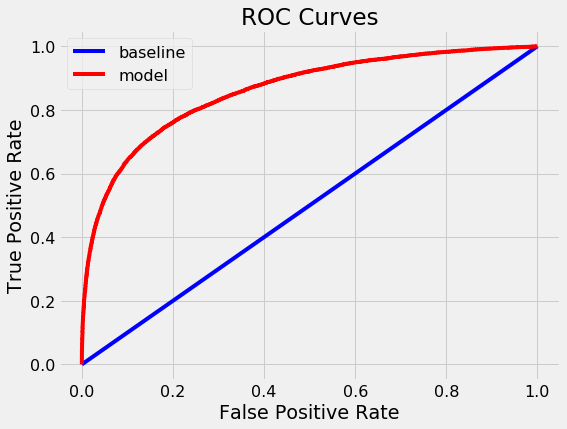

In [95]:
evaluate_model(gbm_predictions, gbm_probs, train_gbm_predictions, train_gbm_probs)

## Comfusion matrix

In [96]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[35182  3859]
 [ 4592  8143]]


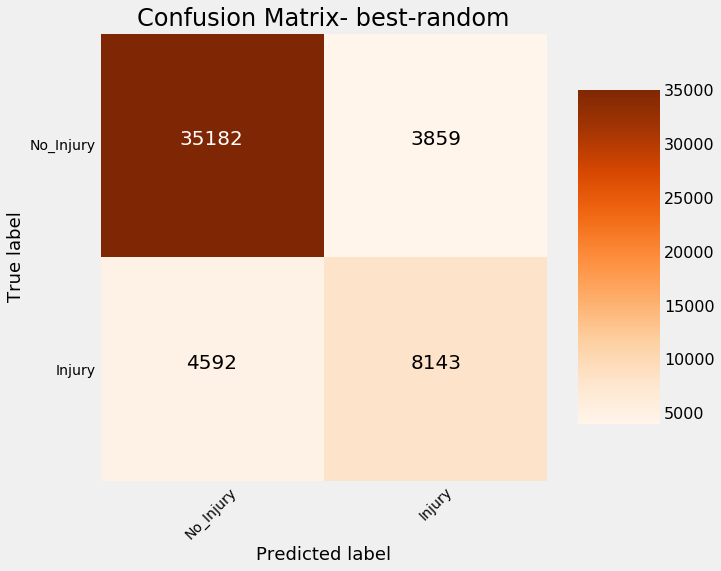

In [98]:
cm = confusion_matrix(test_labels, gbm_predictions)
plot_confusion_matrix(cm, classes = ['No_Injury', 'Injury'],
                      title = 'Confusion Matrix- best-random')

##  Optimization through Random Search

Random search is surprisingly efficient compared to grid search. Although grid search will find the optimal value of hyperparameters (assuming they are in your grid) eventually, random search will usually find a "close-enough" value in far fewer iterations. This great paper explains why this is so: grid search spends too much time evaluating unpromising regions of the hyperparameter search space because it has to evaluate every single combination in the grid. Random search in contrast, does a better job of exploring the search space and therefore can usually find a good combination of hyperparameters in far fewer iterations.

Random search can also be thought of as an algorithm: randomly select the next set of hyperparameters from the grid! We can build a dictionary of hyperparameters by selecting one random value for each hyperparameter as follows (again accounting for subsampling):

We will run with the different set of hyperparameters for this time

In [127]:
random_grid = {'boosting_type': ['gbdt','dart'],
   'colsample_bytree': [0.7125187075392453, 0.812],
   'learning_rate': [0.022592570862044956,0.1],
   'min_child_samples': [200,220,250],
   'num_leaves': [10,20,30,40],
   'reg_alpha': [0.2035211643104735,0.1],
   'reg_lambda': [0.6455131715928091,0.5],
   'subsample': [0.983566228071919,1],
   'subsample_for_bin': [200000,100000]}

In [ ]:

random_clf =  lgb.LGBMClassifier(objective='binary',class_weight='balanced',
                               n_estimators = 10000)

gbm_random = RandomizedSearchCV(estimator=random_clf, param_distributions=random_grid,
                              n_iter = 100, scoring='roc_auc', 
                              cv = 2, verbose=2, random_state=2003, n_jobs=-1,
                              return_train_score=True)

gbm_random.fit(train_small,train_labels) 

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 33.3min


In [ ]:
train_gbm_predictions = base_clf.predict(train_small)
train_gbm_probs = base_clf.predict_proba(train_small)[:, 1]

gbm_predictions = base_clf.predict(test_small)
gbm_probs = base_clf.predict_proba(test_small)[:, 1]

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

train_auc = roc_auc_score(train_labels, train_gbm_probs)
test_auc = roc_auc_score(test_labels, gbm_probs)

print(f'Train ROC AUC Score: {train_auc}')
print(f'Test ROC AUC  Score: {test_auc}')

In [108]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

In [109]:
# Create a default model
model = lgb.LGBMModel()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [110]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Splitting data
from sklearn.model_selection import train_test_split

N_FOLDS = 5
MAX_EVALS = 5

- We will use early stopping to determine perhaps the most important hyperparameter, the number of individual learners trained, n_estimators (also referred to as num_boost_rounds or the number of iterations). Some of the hyperparameters do not need to be tuned if others are: for example, min_child_samples and min_child_weight both limit the complexity of individual decision trees by adjusting the minimum leaf observation requirements and therefore we will only adjust one. However, there are still many hyperparameters to optimize, and we will choose 10 to tune.

- Choosing a hyperparameter grid is probably the most difficult part of hyperparameter tuning: it's nearly impossible ahead of time to say which values of hyperparameters will work well and the optimal settings will depend on the dataset. 


In [114]:
random.seed(2003)

# Randomly sample from dictionary
random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
# Deal with subsample ratio
random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

random_params

{'boosting_type': 'gbdt',
 'num_leaves': 76,
 'learning_rate': 0.01903489935701143,
 'subsample_for_bin': 100000,
 'min_child_samples': 445,
 'reg_alpha': 0.5102040816326531,
 'reg_lambda': 0.9387755102040816,
 'colsample_bytree': 0.6444444444444444,
 'subsample': 0.9494949494949496,
 'is_unbalance': True}

Next, we define the random_search function. This takes the same general structure as grid_search except for the method used to select the next hyperparameter values. Moreover, random search is always run with a limit on the number of search iterations.

In [112]:
def random_search(param_grid, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [113]:
random_results = random_search(param_grid)

print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(random_results.loc[0, 'params'])

NameError: name 'objective' is not defined

One aspect to note is that if boosting_type is goss, then we cannot use subsample (which refers to training on only a fraction of the rows in the training data, a technique known as stochastic gradient boosting). Therefore, we will need a line of logic in our algorithm that sets the subsample to 1.0 (which means use all the rows) if boosting_type=goss. As an example below, if we randomly select a set of hyperparameters, and the boosting type is "goss", then we set the subsample to 1.0.

In [77]:
import random

random.seed(50)

# Randomly sample a boosting type
boosting_type = random.sample(param_grid['boosting_type'], 1)[0]

# Set subsample depending on boosting type
subsample = 1.0 if boosting_type == 'goss' else random.sample(param_grid['subsample'], 1)[0]

print('Boosting type: ', boosting_type)
print('Subsample ratio: ', subsample)

Boosting type:  goss
Subsample ratio:  1.0


In [78]:
# Create a base model
gbm_model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss',
                               eval_metric='auc',n_estimators = 10000, class_weight = 'balanced')
    

# Instantiate the grid search model
gbm_random = RandomizedSearchCV(estimator=gbm_model, param_distributions=param_grid,
                              n_iter = 100, scoring='roc_auc', 
                              cv = 3, verbose=2, random_state=2003, n_jobs=-1,
                              return_train_score=True)

In [ ]:
param_grid_1 = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [1000,4000,10000]
}

gbm = GridSearchCV(estimator=gbm_model, param_distributions=param_grid_1, cv=3)


In [79]:
gbm_random.fit(train_small, train_labels, early_stopping_rounds=100)



OverflowError: Python int too large to convert to C long

In [ ]:
best_grid = grid_search.best_estimator_

## Result

In [ ]:
train_gbm_predictions = best_grid.predict(train_small)
train_gbm_probs = best_grid.predict_proba(train_small)[:, 1]

gbm_predictions = best_grid.predict(test_small)
gbm_probs = best_grid.predict_proba(test_small)[:, 1]

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

train_auc = roc_auc_score(train_labels, train_gbm_probs)
test_auc = roc_auc_score(test_labels, gbm_probs)

print(f'Train ROC AUC Score: {train_auc}')
print(f'Test ROC AUC  Score: {test_auc}')

In [ ]:
def evaluate_model(predictions, probs, train_predictions, train_probs:
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [ ]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [ ]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['No_Injury', 'Injury'],
                      title = 'Confusion Matrix- best-random')